# Scraping Data Jobs with Python and Selenium

As a data professional, I am always on the hunt for exciting new opportunities. 

I wanted to build a simple webscraper to pu


### NOTES
1) cool [post](https://towardsdatascience.com/gone-to-find-myself-finding-where-i-am-in-the-data-science-world-by-web-scraping-job-postings-bf416dbfb6fa) about this! 
2) Another cool [post](https://towardsdatascience.com/web-scraping-indeed-com-e5591790736d) more stats/ML based
3) Start super simple and then build your way up. Post a medium article to get something out there!
4) Do a Selenium and Beautiful Soup Version
5) Scrape data, visualize data. 
6) more reading and examples: https://towardsdatascience.com/the-most-in-demand-skills-for-data-scientists-in-2021-4b2a808f4005
7) more reading and examples:https://medium.com/@alex.kirkup/web-scraping-2023-data-science-jobs-listings-to-extract-the-key-skills-required-2359bfab176e

In [1]:
from driver_builder import DriverBuilder
from selenium.webdriver.common.by import By
import pandas as pd
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import logging
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style(style="darkgrid")

job_board = 'https://datajobs.com/'
# this pattern pulls jobs specifically from datajobs
pattern = r"<a href=\"(.*)\"><strong>(.*)</strong> – <span [^\>]*>(.*)</span></a>[\n\s]*</div>[\n\s]*<div[^\>]*>[\n\s]*<em>[\n\s]*<span[^\>]*>(.*)</span>[\n\s]*[\&nbsp;\•]*[\n\s]*\$*([\d,]*)[–\s]*\$*([\d,]*)[\n\s]*</em>"
col_list = [
    'url',
    'title',
    'company',
    'location',
    'salary_lower',
    'salary_upper'
]

state_codes = ['AL','AK','AZ','AR','CA','CO','CT','DE','DC','FL','GA','HI','ID','IL','IN',
'IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC',
'ND','OH','OK','OR','PA','PR','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY'
]

buzz_words = [
'Python',
'C++',
'C',
'C#',
'Julia',
'R',
'PHP',
'Java',
'SAS',
'Javascript',
'Scala',
'SQL',
'Visualization',
'Machine Learning',
'Deep Learning',
'Hadoop',
'Spark', 
'Tensorflow',
'Pytorch',
'Webscrap',
'matplotlib',
'seaborn',
'plotly',
'shiny',
'pandas',
'numpy',
'scikit-learn',
'scikit learn',
'scikitlearn',
'keras',
'scipy',
'AWS',
'Amazon Web Services',
'GCP',
'Google Cloud Platform',
'Azure',
'Tableau',
'PowerBI',
'Power-BI',
'Power Bi',
'Docker',
'Kubernetes',
'Airflow',
'NoSQL',
'MongoDB',
'MySQL',
'PostgreSQL',
'Oracle',
'Snowflake',
'Linux',
'Unix',
'CNN',
'LSTM',
'RNN',
'LLM',
'Recommender',
'Causal Inference',
'Time Series',
'Time-Series',
'A/B Testing',
'A-B Testing',
'AB Testing',
'Perl',
'Excel',
'Google Sheets'
]

wait_time = 3
PATH = '/home/colin/Documents/Code/DS Projects/Wellfound Webscraper/DATA'
LOG_PATH = '/home/colin/Documents/Code/DS Projects/Wellfound Webscraper/LOGS'
HEADLESS = False
WAIT_TIME = 10

logging.basicConfig(
    filename=LOG_PATH + "/main.log",
    format="%(levelname)s - %(asctime)s:%(message)s",
    encoding="utf-8",
    level=logging.INFO,
)



# TODO: Make this work on multiple sites
# TODO: Grab job desciptions as well

In [2]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
def cleanhtml(raw_html):
    raw_html2  = re.sub("(<!--.*?-->)", "", raw_html, flags=re.DOTALL)
    cleantext = re.sub(CLEANR, ' ', raw_html2)
    return cleantext

class DataJobsScraper():

    def __init__(self, site):
        
        self._site = site
        self.job_meta = pd.DataFrame(columns = [
                                            'url',
                                            'title',
                                            'company',
                                            'location',
                                            'salary_lower',
                                            'salary_upper',
                                            'job_category'
                                        ])
        

    def scrape_jobs(self):
        driver_builder = DriverBuilder()
        self._driver = driver_builder.get_driver(download_location=PATH, headless=HEADLESS)

        if self._site == 'DataJobs':
            self._site_url = 'https://datajobs.com/'
            # there are two different boards on this website
            board_paths = ["/Data-Science-Jobs", "/Data-Engineering-Jobs"]
            # loop through the boards available
            for bp in board_paths:
                if bp == "/Data-Science-Jobs":
                    cat = 'Data Science & Analytics'
                else:
                    cat = 'Data Engineering'
                # load into the webpage
                self._driver.get(self._site_url + bp)
                more_pages = True # will kill the loop when there are no more pages
                i = 0 # just a counter to kill the loop just in case
                while more_pages:
                    # grab page source html
                    page_html = self._driver.page_source

                    # grab job info
                    fall = re.findall(pattern, page_html)

                    # create pandasable list
                    fall_cols = [dict(zip(self.job_meta.columns, x+(cat,))) for x in fall]

                    # add to dataframe
                    self.job_meta  = pd.concat([self.job_meta, pd.DataFrame(fall_cols)], ignore_index=True)

                    if i == 200:
                        # stop after 200 pages
                        more_pages=False

                    # try to go to next page
                    try:
                        next_page = WebDriverWait(self._driver, wait_time).until(
                            EC.element_to_be_clickable((By.XPATH, "//a[contains(text(), 'NEXT PAGE')]"))
                        )
                        next_page.click()
                        i+=1
                    except:
                        print('END OF SEARCH RESULTS...')
                        more_pages=False

        # just dedup jobs before moving on
        self.job_meta.drop_duplicates(subset = self.job_meta.columns.tolist()[:-1], inplace=True)

    def scrape_job_text(self):
        job_desc_list = []
        
        if self._site == 'DataJobs':
            for _, job in self.job_meta.iterrows():
                job_url = self._site_url + job['url'][1:]
                self._driver.get(job_url)
                # grab job desc element
                try:
                    job_descr = WebDriverWait(self._driver, wait_time).until(
                        EC.element_to_be_clickable((By.XPATH, "//div[@id='job_description']//*[@class='jobpost-table-cell-2']"))
                    )
                except:
                    print(f"I can't find this job: {job['title']}")
                    continue
                # get html
                job_desc_clean = cleanhtml(job_descr.get_attribute('innerHTML'))
                job_desc_list.append({
                    'title':job['title'],
                    'company':job['company'],
                    'desc':job_desc_clean
                })
        
        self.job_descriptions = pd.DataFrame(job_desc_list)
    
    def clean_data(self):
        # let's clean up the data a bit
        # I noticed that New York City, NY is just represented as New York City. This doesn't work for pulling out the states later so let's just replace it
        self.job_meta.location = self.job_meta.location.replace({'New York City': 'New York City, NY'})
        # This is an HTML code for ampersand. Let's just replace it with an actual ampersand
        self.job_meta['title'] = self.job_meta['title'].replace({'&amp;':'&'})
        # Let's get the states (note, there are non-US jobs in this dataset)
        self.job_meta['state'] = self.job_meta.loc[:,'location'].fillna('').apply(lambda x: x.replace(' ', '').split(',')[1] if ',' in x else x)
        # finally, let's clean up the job titles a bit based on some hard coded rules. This is not fool proof but it gives us a much better idea of what jobs are on this site.
        self.job_meta['clean_title'] = self.job_meta['title'].apply(clean_title)

    def export_data(self, data_path):
        self._driver.close()
        # TODO: Fix comma issue, maybe just by making things excel files
        self.job_meta.to_csv(f"{data_path}/{self._site}_job-meta.csv", index=False)
        self.job_descriptions.to_csv(f"{data_path}/{self._site}_job-descriptions.csv", index=False)


def clean_title(title):
    temp_title = title.lower().replace(' ','')
    # let's just lump leadership/management positions into one category since we aren't really looking for these
    if 'headof' in temp_title or 'chief' in temp_title or 'president' in temp_title or 'director' in temp_title or 'manager' in temp_title:
        return 'Leadership'
    # software engineering is also not quite what we're looking for
    elif 'software' in temp_title and ('engineer' in temp_title or 'developer' in temp_title):
        return 'Software Engineer'
    # here we are mapping the standard data positions. Note that job titles can be Data Scientist - Ads or something like that, this helps us just grab the position title
    elif 'data' in temp_title:
        if 'scientist' in temp_title:
            return 'Data Scientist'
        # here we are generalizing a lot of different positions into one. It's ok for a general overview
        # NOTE: This logic will capture the 'Data Science Engineer' role, since Data Engineering tends to be more in demand, I'm ok with that.
        elif 'engineer' in temp_title or 'warehouse' in temp_title or 'architect' in temp_title or 'base' in temp_title:
            return 'Data Engineer'
        elif 'analyst' in temp_title:
            return 'Data Analyst'
        else:
            return title
    # BI Engineer could probably be lumped into data analyst if necessary; although, in big companies they can be very different
    elif ('business' in temp_title and 'intelligence' in temp_title) or ('business' in temp_title and 'analyst' in temp_title) or 'bi ' in title.lower():
        return 'BI Engineer'
    # this is highly specific we could probably stand to workshop this a bit
    elif 'machine' in temp_title and 'learning' in temp_title and ('engineer' in temp_title or 'scientist' in temp_title):
        return 'Machine Learning Engineer'
    # this captures all the analysts not caught in the 'data' step
    elif 'analyst' in temp_title: 
        return 'Data Analyst'
    elif 'statistician' in temp_title:
        return 'Statistician'
    elif 'hadoop' in temp_title:
        return 'Data Engineer'
    else:
        return title
    



In [3]:
scrape_data = False
if scrape_data:

    djs = DataJobsScraper(site='DataJobs')
    djs.scrape_jobs()
    djs.scrape_job_text()
    djs.clean_data()
    djs.export_data(data_path=PATH)

job_meta = pd.read_csv(PATH + "/DataJobs_job-meta.csv")
job_descriptions = pd.read_csv(PATH + "/DataJobs_job-descriptions.csv")

### some styling options

1) https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08


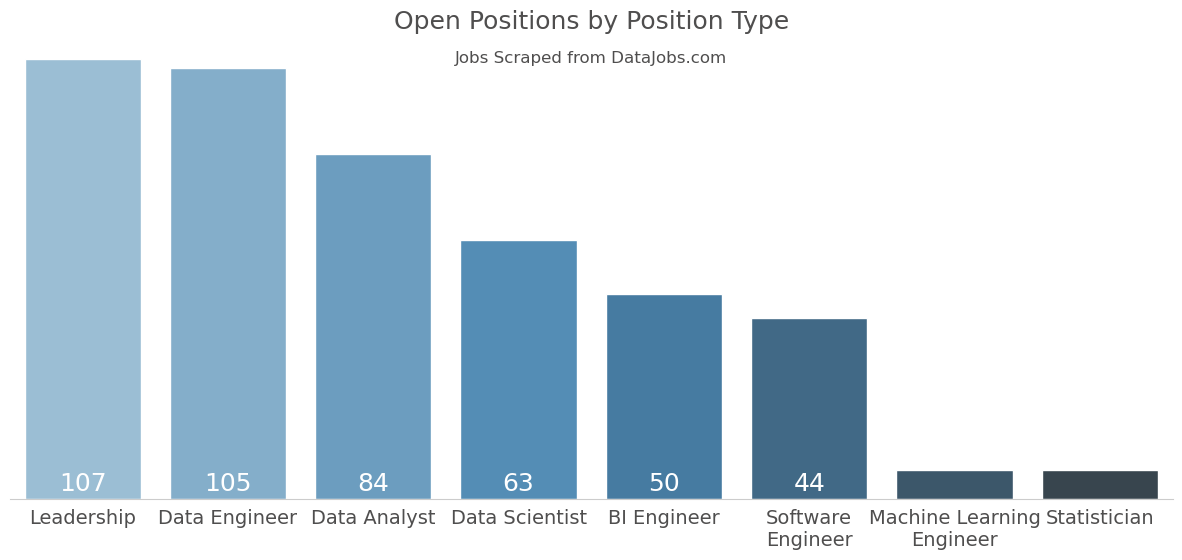

In [41]:
sns.set_style("whitegrid")
# when you're ready to export uncomment this for a sharper image
# plt.rcParams['figure.dpi'] = 360

f, ax = plt.subplots(figsize=(15,6))
# there are a lot of duplicates accross the categories
clean_title_counts = job_meta['clean_title'].value_counts().reset_index()

# Plot the cats
sns.set_color_codes("pastel")
sns.barplot(x='clean_title', y="count", data=clean_title_counts[clean_title_counts['count'] > 1],
            label="Number of Jobs per Category", palette="Blues_d", ax = ax)
sns.despine(left=True)
# ax.bar_label(ax.containers[0]);

for idx, lbl in enumerate(list(ax.containers[0])):
    h = int(lbl.get_height())
    if h > 10:
        plt.text(x=idx, y=2, s=f"{int(lbl.get_height())}", color='white',fontsize=18, horizontalalignment='center')


# ax.set_ylabel('Number of Positions', size=18, color='#4f4e4e');
ax.set_ylabel('')
ax.set_xlabel('');
ax.set_title(f'Open Positions by Position Type', size=18, color='#4f4e4e');
plt.text(x=3.5, y=106, s='Jobs Scraped from DataJobs.com', 
                 color='#4f4e4e', fontsize=12, horizontalalignment='center')
plt.xticks(size=14, color='#4f4e4e');
# plt.yticks(size=14, color='#4f4e4e');
plt.yticks([],[]);

# let's fix the MLE text
labels = [item.get_text() for item in ax.get_xticklabels()]
for idx, label in enumerate(labels):
    if label == "Machine Learning Engineer":
        labels[idx] = "Machine Learning\nEngineer"
    elif label == 'Software Engineer':
        labels[idx] = "Software\nEngineer"

ax.set_xticklabels(labels = labels);

plt.savefig('FIGS/position_types.png');

<Axes: xlabel='count', ylabel='state'>

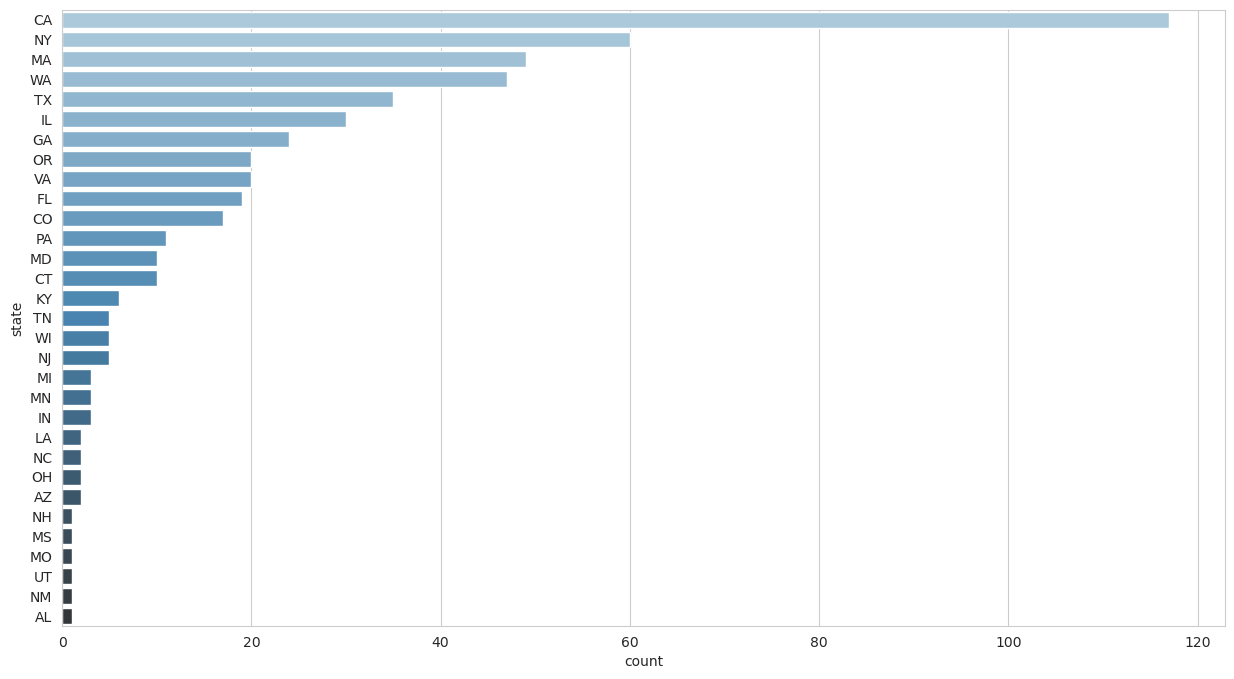

In [42]:

# do a geospatial map for this
# https://medium.com/@alex_44314/use-python-geopandas-to-make-a-us-map-with-alaska-and-hawaii-39a9f5c222c6
f, ax = plt.subplots(figsize=(15,8))
num_states = job_meta[job_meta['state'].isin(state_codes)]['state'].value_counts().reset_index().sort_values(by="count", ascending=False)
# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(y='state', x="count", data=num_states,
            label="Alcohol-involved", palette="Blues_d", ax = ax, orient='h')

In [6]:
buzz_word_counts = {kwd:0 for kwd in buzz_words if kwd not in ('scikitlearn', 'scikit learn', 'Power-BI', 'Power BI', 'Time Series','A-B Testing','AB Testing', 'Amazon Web Services', 'Google Cloud Platform', 'Webscrap')}
buzz_word_counts['Webscraping'] = 0

job_descriptions['naiive_keywords'] = None

for idx, row in job_descriptions.iterrows():
    bw_list = []
    # note: I am purposefully excluding '-' here for hyphen words like 'c-span'. we do not want that to match on 'c'
    desc2 = ' ' + re.sub(r'[^A-Za-z0-9-\+#]+', ' ', row['desc']).lower() + ' '
    for kwd in buzz_words:
        kwd2 = ' ' + kwd.lower() + ' '
        # adding spaces here prevents us from matching on subsets of words. e.g matching on the 'c' in 'coin'
        if kwd2 in desc2: 
            if kwd in ('scikit-learn', 'scikitlearn', 'scikit learn'):
                buzz_word_counts['scikit-learn'] += 1
                bw_list.append('scikit-learn')
            elif kwd in ('PowerBI', 'Power-BI', 'Power BI'):
                buzz_word_counts['PowerBI'] += 1
                bw_list.append('PowerBI')
            elif kwd in ('Time Series', 'Time-Series'): 
                buzz_word_counts['Time-Series'] += 1
                bw_list.append('Time-Series')
            elif kwd in ('A/B Testing','A-B Testing','AB Testing'):
                buzz_word_counts['A/B Testing'] += 1
                bw_list.append('A/B Testing') 
            elif kwd == 'Google Cloud Platform':
                buzz_word_counts['GCP'] += 1
                bw_list.append('GCP')  
            elif kwd == 'Amazon Web Services':
                buzz_word_counts['AWS'] += 1
                bw_list.append('AWS') 
            elif kwd == 'Webscrap':
                buzz_word_counts['Webscraping'] += 1
                bw_list.append('Webscraping')                              
            else:     
                buzz_word_counts[kwd] += 1
                bw_list.append(kwd)
    job_descriptions.loc[idx, 'naiive_keywords'] = ', '.join(bw_list)

sorted_bw_count = {}
for w in sorted(buzz_word_counts, key=buzz_word_counts.get, reverse=True):
    sorted_bw_count[w] = buzz_word_counts[w]

In [7]:
job_descriptions.sample(5)

,title,company,desc,naiive_keywords
276,Scientific Visualization Developer,"Kitware, Inc.",\n Company Descriptio...,"C++, R, Javascript, Visualization"
308,Pricing Analyst,Wayfair,\n Wayfair is looking ...,SQL
187,Decision Science Consultant,Disney Parks &amp; Resorts,\n Create innovative ...,"Python, C++, C, Julia, R, Java, SAS, Machine L..."
106,Data Analyst,Center for American Progress,\n Reports to: Senio...,"Visualization, Tableau, Power Bi, Excel"
311,Database Administrator with Hadoop and MySQL,Rosetta Stone,\n Job Profile Summar...,"SQL, Hadoop, MongoDB, MySQL"


In [8]:
sorted_bw_count.values()

dict_values([304, 187, 141, 135, 127, 121, 113, 107, 101, 85, 68, 68, 59, 56, 53, 51, 51, 46, 43, 41, 41, 36, 29, 25, 24, 18, 14, 13, 11, 11, 9, 9, 9, 8, 8, 8, 7, 6, 5, 5, 3, 3, 3, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

/home/colin/miniconda3/envs/wellfound/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

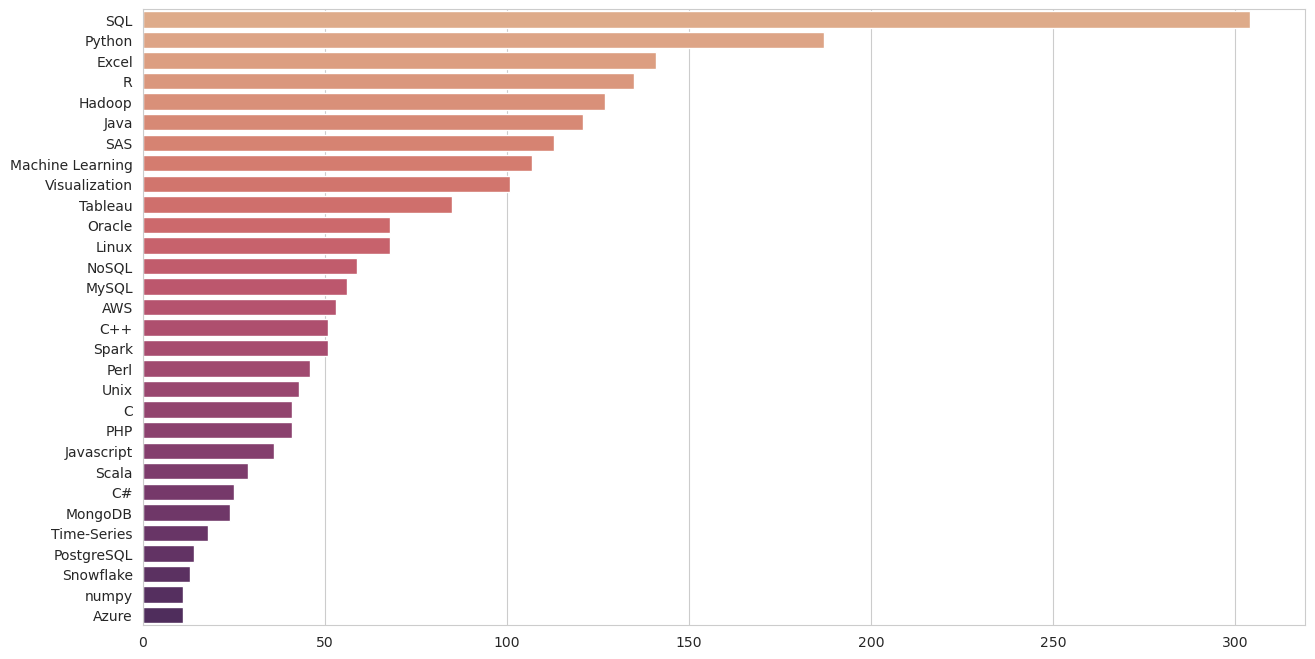

In [9]:
# Plot the crashes where alcohol was involved

viz_counts = {k:v for k, v in sorted_bw_count.items() if v >=10}

f, ax = plt.subplots(figsize=(15,8))
sns.set_color_codes("muted")
sns.barplot(y=list(viz_counts.keys()), x=list(viz_counts.values()), palette="flare", ax=ax, orient='h')

### Some More Advanced Viz.

1) Word Cloud
2) 

In [10]:
# let's try it with removing stop words
from nltk.corpus import stopwords

# Create a set of stop words 
stop_words = set(stopwords.words('english')) 

buzz_word_counts2 = {kwd:0 for kwd in buzz_words}

for descrip in job_descriptions['desc']:
    word_tokens = re.sub(r'[^A-Za-z0-9-\+#]+', ' ', descrip).split()
    filtered_descrip = ' '.join([w.lower() for w in word_tokens if not w.lower() in stop_words])
    for kwd in buzz_words:
        if ' ' + kwd + ' ' in filtered_descrip: 
            buzz_word_counts2[kwd] += 1

sorted_bw_count2 = {}
for w in sorted(buzz_word_counts2, key=buzz_word_counts2.get, reverse=True):
    sorted_bw_count2[w] = buzz_word_counts2[w]